# Problem Set 4
### By Scott Behmer. February 4, 2018

This Jupyter notebook contains my answers to problems one and two from problem set four. For the code to run properly, the datasets "usincmoms.txt" and "MacroSeries.txt" will have to be in the folder of the Jupyter Notebook.

## Problem 1. GMM estimation with US income distribution
The cell below imports the required packages, loads the data, and makes some corrections. 

In [33]:
# Import packages
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#Setting plot colors
cmap1 = matplotlib.cm.get_cmap('summer')
%matplotlib notebook

#Loading the dataset
pts = np.loadtxt('usincmoms.txt')

#Creating separate arrays for x-values (incomes) and y-values (frequencies)
incomes = pts[:, 1]
freqs = pts[:, 0]
#Creating an array for the width of each bin. Each is five units wide (representing 5 thousand dollars) except for the last two.
widths = np.ones(len(incomes))*5
#Correcting last two bins
widths[len(widths)-1] = 100
widths[len(widths)-2] = 50
#Correcting the frequency values for the last two bins to reflect the fact that they are wider.
freqs[len(widths)-1] = freqs[len(widths)-1]/20
freqs[len(widths)-2] = freqs[len(widths)-2]/10

## Part A. Creating a histogram

Because the histogram will be superimposed with pdfs, the y-axis values need to represent probability densities rather than frequencies. For this reason, the frequency values are divided by five (the bin-width). Also note that the x-axis is in units of thousands of dollars.

<IPython.core.display.Javascript object>


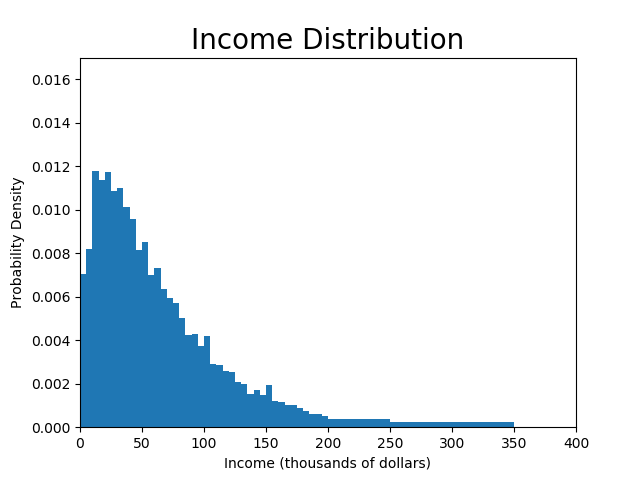

In [64]:
#Creating histogram
plt.bar(incomes/1000.0, freqs/5, widths)
plt.title('Income Distribution', fontsize=20)
plt.xlabel('Income (thousands of dollars)')
plt.ylabel('Probability Density')
plt.xlim([0, 400]);
plt.ylim([0, 0.017]);

## Part B. Fitting a log normal distribution using GMM

The cell below defines five functions:
1. The log normal pdf function. This takes as input an x-value as well as two parameter values. It outputs the pdf value.
2. The data moment function. This outputs a vector of data moments, which is just the bin frequency divided by the bin width.
3. The model moment function. For a given set of parameter values, this function outputs a vector filled with the probabilities of a data point being in each bin.
4. The error vector function. This caclulates the relative error vector between the data moments and the model moments.
5. The criterion function. The output of this function is given by $e^{T}We$ where e is the error vector and W is the weighting matrix, which in our case is the matrix of bin frequencies. This is the function that is minimized to find the GMM parameter estimates.

In [35]:
def lnpdf(x, mu, sigma):
    pdf = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-((np.log(x)-mu)**2)/(2*sigma*sigma))
    return pdf

def mom_data(freqs, incomes):
    return freqs/5000

def mom_model(mu, sigma, freqs, incomes):
    moments = np.zeros(len(freqs))
    moments[0] = sts.norm.cdf(np.log(incomes[0]+2500.0), mu, sigma)
    f = len(freqs)
    for i in range(1, f-2):
        moments[i] = sts.norm.cdf(np.log(incomes[i]+2500.0), mu, sigma) - sts.norm.cdf(np.log(incomes[i]-2500.0), mu, sigma)
    moments[f-1] = sts.norm.cdf(np.log(incomes[f-1]+50000), mu, sigma) - sts.norm.cdf(np.log(incomes[f-1]-50000), mu, sigma)
    moments[f-2] = sts.norm.cdf(np.log(incomes[f-2]+25000), mu, sigma) - sts.norm.cdf(np.log(incomes[f-2]-25000), mu, sigma)
    return moments

def error(mu, sigma, freqs, incomes):
    errorvec = 100*(mom_data(freqs, incomes) - mom_model(mu, sigma, freqs, incomes))/mom_data(freqs, incomes)
    return errorvec
    
def crit(params, *args):
    mu, sigma = params
    freqs, incomes, W = args
    err = error(mu, sigma, freqs, incomes)
    criterion = np.dot(np.dot(err.T, W), err)
    return criterion

The next cell runs the optimization and prints out the resulting parameter values and function value. We see that the optimization was successful. Initial parameter values can be adjusted and the optimization will end up with similar results.

The following cell plots the resulting pdf onto the histogram. We see that it significantly overestimates the density at low income values, but does a better job with the upper tail.

In [36]:
#Setting initial values
sig_init = 1
mu_init = np.log(np.dot(freqs, incomes))
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(freqs)
gmm_args = (freqs, incomes, W_hat)
results = opt.minimize(crit, params_init, args=(gmm_args),
                       method='Nelder-Mead')
mu_gmm, sigma_gmm = results.x
print('mu_gmm: ', mu_gmm, "sigma_gmm: ", sigma_gmm)
print('The resulting criterion value is: ', results.fun)
results

mu_gmm:  10.6425239054 sigma_gmm:  0.738694165786
The resulting criterion value is:  303865164793.0


 final_simplex: (array([[ 10.64252391,   0.73869417],
       [ 10.64252388,   0.73869416],
       [ 10.64252391,   0.73869415]]), array([  3.03865165e+11,   3.03865165e+11,   3.03865165e+11]))
           fun: 303865164793.34161
       message: 'Optimization terminated successfully.'
          nfev: 119
           nit: 64
        status: 0
       success: True
             x: array([ 10.64252391,   0.73869417])

In [63]:
dist_pts = np.linspace(0.00001, 400, 500)
#plt.plot(dist_pts, (1/dist_pts)*sts.norm.pdf(np.log(dist_pts*1000), mu_gmm, sigma_gmm),
         #linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.plot(dist_pts, 1000*lnpdf(dist_pts*1000, mu_gmm, sigma_gmm),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$');
plt.legend(loc='upper right');

## Part C. Fitting a Gamma Distribution with GMM.

The following cell defines the pdf, model moments, data moments, error vector, and criterion function for the gamma distribution.

In [38]:
import scipy.special as spc

def gamma_pdf(xvals, alpha, beta):
    pdfvals = (1/(beta**alpha))*(xvals**(alpha-1))*np.exp(-(xvals/beta))/(spc.gamma(alpha))
    return pdfvals

def mom_model2(alpha, beta, freqs, incomes):
    moments = np.zeros(len(freqs))
    xfx = lambda x: gamma_pdf(x, alpha, beta)
    f = len(freqs)
    for i in range(0, f-2):
        moments[i] = intgr.quad(xfx,incomes[i]-2500.0, incomes[i]+2500.0)[0]
    moments[f-1] = intgr.quad(xfx,incomes[f-1]-50000.0, incomes[f-1]+50000.0)[0]
    moments[f-2] = intgr.quad(xfx,incomes[f-2]-25000.0, incomes[f-2]+25000.0)[0]
    return moments

def error2(mu, sigma, freqs, incomes):
    errorvec = 100*(mom_data(freqs, incomes) - mom_model2(mu, sigma, freqs, incomes))/mom_data(freqs, incomes)
    return errorvec
    
def crit2(params, *args):
    mu, sigma = params
    freqs, incomes, W = args
    err = error2(mu, sigma, freqs, incomes)
    criterion = np.dot(np.dot(err.T, W), err)
    return criterion

The next cell estimates the parameter values that minimize the criterion function. We see that the minimization terminates successfully, and these results seem to be robust to changes in initial conditions. The resulting criterion value is 2.7e11, which is lower than that resulting from the log normal distribution (3.0e11), which suggests that the gamma distribution better fits the data.

In [39]:
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
W_hat = np.diag(freqs)
gmm_args = (freqs, incomes, W_hat)
results = opt.minimize(crit2, params_init, args=(gmm_args),
                       method='Nelder-Mead')
alpha_gmm, beta_gmm = results.x
print('alpha_gmm:', alpha_gmm, "beta_gmm:", beta_gmm)
print('The resulting criterion value is: ', results.fun)
results

alpha_gmm: 1.6655612184 beta_gmm: 33172.1832267
The resulting criterion value is:  270978492576.0


 final_simplex: (array([[  1.66556122e+00,   3.31721832e+04],
       [  1.66556121e+00,   3.31721833e+04],
       [  1.66556122e+00,   3.31721833e+04]]), array([  2.70978493e+11,   2.70978493e+11,   2.70978493e+11]))
           fun: 270978492576.38464
       message: 'Optimization terminated successfully.'
          nfev: 137
           nit: 70
        status: 0
       success: True
             x: array([  1.66556122e+00,   3.31721832e+04])

## Parts C and D: Plotting the gamma distribution to the histogram

The cell below adds the gamma pdf to our histogram. We see that it seems to be a better approximation of the data at all income levels than the log normal pdf, which is what we would expect given the lower criterion value.

In [61]:
dist_pts = np.linspace(0.00001, 400, 500)
#plt.plot(dist_pts, (1/dist_pts)*sts.norm.pdf(np.log(dist_pts*1000), mu_gmm, sigma_gmm),
         #linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.plot(dist_pts, 1000*gamma_pdf(dist_pts*1000, alpha_gmm, beta_gmm),
         linewidth=2, color='r', label='2: $\alpha_{GMM}$,$\beta_{GMM}$');
plt.legend(loc='upper right');

## Part E. Fitting gamma distribution using two-step weighting matrix.

The code below first fits the gamma distribution using the identity matrix as the weighting matrix. This optimization does not successfully exit (even after I increased the maximimum number of function iterations), but it does result in fairly reasonable parameter values. I then use the resulting error vector to calculate the two-step weighting matrix. The optimization using this matrix leads to strange parameter values that do not fit the data very well for most income levels.

Note that even if the first step estimates are calculated using the weighting matrix from part c, we end up with similar results. I am not sure if there is an error somewhere in my code or if this is actually the correct result. An error seems unlikely, as I am using the exact same functions from part c (which seemed to work well), only with a different weighting matrix. 

In [41]:
#First Step
#------------------------------------
#For the first step, the weighting matrix is the identity matrix
W_hat1 = np.eye(len(freqs))

#Minimize criterion function with the identity matrix
params_init = np.array([alpha_gmm, beta_gmm])
gmm_args = (freqs, incomes, W_hat1)
results = opt.minimize(crit2, params_init, args=(gmm_args),
                       method='Nelder-Mead', options = {'maxiter' : 1000})
alpha_gmm1, beta_gmm1 = results.x
print('alpha_gmm: ', alpha_gmm1, "beta_gmm: ", beta_gmm1)
results

#-----------------------------------
#Second Step
#-----------------------------------

#Calculating two-step weighting matrix
err1 = error2(alpha_gmm1, beta_gmm1, freqs, incomes)
VCV2 = np.outer(err1, err1) / len(freqs)
W_hat2 = lin.pinv(VCV2)

#Now minimize the criterion function with the new weighting matrix
params_init = np.array([alpha_gmm1, beta_gmm1])
gmm_args = (freqs, incomes, W_hat2)
results = opt.minimize(crit2, params_init, args=(gmm_args),
                       method='Nelder-Mead')
alpha_gmm2, beta_gmm2 = results.x

#Printing Results
print('alpha_gmm: ', alpha_gmm2, "beta_gmm: ", beta_gmm2)
print('The resulting criterion value is: ', results.fun)
results

alpha_gmm:  1.98828793875 beta_gmm:  20381.6826221


C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Scott\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


alpha_gmm:  56.6035206418 beta_gmm:  2600.75149908
The resulting criterion value is:  28.5512141942


 final_simplex: (array([[   56.60352064,  2600.75149908],
       [   56.60352064,  2600.75156913],
       [   56.60352064,  2600.7515263 ]]), array([ 28.55121419,  28.55121419,  28.55121419]))
           fun: 28.551214194233967
       message: 'Optimization terminated successfully.'
          nfev: 286
           nit: 156
        status: 0
       success: True
             x: array([   56.60352064,  2600.75149908])

The cell below adds the estimated distribution usig the two-step weighting matrix to our plot from part a. Here we see that the resulting parameter values are a very poor fit of the data. The pdf is no where near the histogram for nearly all income levels. 

In [58]:
dist_pts = np.linspace(0.00001, 400, 500)
plt.plot(dist_pts, 1000*gamma_pdf(dist_pts*1000, alpha_gmm2, beta_gmm2),
         linewidth=2, color='g', label='3: $\alpha_{GMM}2$,$\beta_{GMM}2$');
plt.legend(loc='upper right');

C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


Although it is not very important considering how poor our results from this section fit the data, we can consider how to quantitatively compare the goodness of fit from these results to those from part c. A quantitative comparison of goodness of fit is more difficult for this part because the criterion functions cannot be directly compared. One measure of goodness of fit is an analog of the $R^2$ value from linear regression: one can check the average distance between the predicted values and the actual values. However, in this context that would simply be the criterion function from part c (assuming that we would want to weight the R^2 by the frequency of observations at each income level), and since our estimates in part c maximized that criterion function, of course they will be a better fit than our estimates from part d. If we did not want to weight by frequencies, we could just square the error vectors. Here we also find that the estimate from part c is a much better fit.

Below both calculations are presented. The first uses the weighted criterion function from part c. The next uses the unweighted criterion.

In [43]:
print('Weighted Criterion with Part C results:', crit2(np.array([alpha_gmm, beta_gmm]), freqs, incomes, W_hat))
print('Weighted Criterion with Part E results:', crit2(np.array([alpha_gmm2, beta_gmm2]), freqs, incomes, W_hat))
print('Unweighted Criterion with Part C results:', crit2(np.array([alpha_gmm, beta_gmm]), freqs, incomes, W_hat1))
print('Unweighted Criterion with Part E results:', crit2(np.array([alpha_gmm2, beta_gmm2]), freqs, incomes, W_hat1))

Weighted Criterion with Part C results: 270978492576.0
Weighted Criterion with Part E results: 2.37780417925e+12
Unweighted Criterion with Part C results: 1.30976395996e+13
Unweighted Criterion with Part E results: 3.38453151143e+14


## Problem 2. Estimating the Brock and Murman model using GMM

The cell below imports the data

In [44]:
#Importing Data
data = np.loadtxt('MacroSeries.txt', delimiter = ",")

The cell below defines the data moments, model moments, error vector, and criterion function. Four moment conditions are used:
$$ E\left[z_{t+1} - \rho z_t - (1-\rho )\mu \right] = 0 $$
$$ E\left[\left( z_{t+1} - \rho z_t - (1-\rho )\mu\right)z_t \right] = 0  $$
$$ E\left[\beta\alpha e^{z_{t+1}}k^{\alpha -1}_{t+1}\frac{c_t}{c_{t+1}} - 1 \right] = 0 $$
$$ E\left[\left(\beta\alpha e^{z_{t+1}}k^{\alpha -1}_{t+1}\frac{c_t}{c_{t+1}} - 1 \right) w_t \right] = 0 $$

Thus, the model moments are all equal to zero, while the data moments are the empirical analog of the expectation values. For example, the first data moment is given by:
$$ \frac{1}{N-1}\sum z_{t+1} - \rho z_t - (1-\rho )\mu $$
where the sum is taken over all data points except the final time period (because there is no $t+1$ time period for that final point). Note that to calculate the data moments the time series for $z_t$ must first be calculated. This is done using the following equation from the Brock and Murman model:
$$ z_t = ln\left(\frac{w_t}{(1-\alpha)k^{\alpha}_{t}}\right)  $$

In [45]:
def mom_data3(data, alpha, rho, mu, beta):
    z = np.zeros(len(data))
    for i in range(0, len(data)):
        z[i] = np.log(data[i][3]/(alpha*(data[i][1]**(alpha-1))))
    moments = np.zeros(4)
    for i in range(0, len(data)-1):
        moments[0] += z[i+1] - rho*z[i] - (1-rho)*mu
        moments[1] += (z[i+1] - rho*z[i] - (1-rho)*mu)*z[i]
        moments[2] += (beta*alpha*np.exp(z[i+1])*(data[i+1][1]**(alpha-1))*data[i][0]/data[i+1][0]) - 1
        moments[3] += ((beta*alpha*np.exp(z[i+1])*(data[i+1][1]**(alpha-1))*data[i][0]/data[i+1][0]) - 1)/data[i][2]
    return moments

def mom_model3(data, alpha, rho, mu, beta):
    return np.zeros(4)

def error3(data, alpha, rho, mu, beta):
    datamoments = mom_data3(data, alpha, rho, mu, beta)
    errorvec = (datamoments - mom_model3(data, alpha, rho, mu, beta))
    return errorvec
    
def crit3(params, *args):
    alpha, rho, mu, beta = params
    data, W = args
    err = error3(data, alpha, rho, mu, beta)
    criterion = np.dot(np.dot(err.T, W), err)
    return criterion

The next cell minimizes the criterion function to estimate the parameter values. Note that the identity matrix is used for the weighting matrix. Initial guesses for parameter values were taken from our MLE estimation of the Brock and Murman model from problem set 3.

The optimization successfully finds a local minimum near where these initial values are. The resulting criterion value is 6e-6. Notice that, although an unconstrained minimizing method is used, the resulting parameter values are all within their bounds, so this is not a problem. The results are not very robust to the initial conditions, but I have yet to find any initial conditions that lead to a lower criterion value than the 6e-6, so that seems to be a local minimum.

In [46]:
#alpha_init, rho_init, mu_init, beta_init = 0.46, 0.72, 9.45, .99
alpha_init, rho_init, mu_init, beta_init = 0.44, 0.72, 9.45, .99
params_init = np.array([alpha_init, rho_init, mu_init, beta_init])
W_hat = np.eye(4)
gmm_args = (data, W_hat)
results = opt.minimize(crit3, params_init, args=(gmm_args),
                       method='Nelder-Mead')
alpha3_gmm, rho3_gmm, mu3_gmm, beta3_gmm = results.x
print(' alpha_gmm:', alpha3_gmm, ' rho_gmm:', rho3_gmm, ' mu_gmm:', mu3_gmm, ' beta_gmm:', beta3_gmm)
print('The resulting criterion value is: ', results.fun)
results

 alpha_gmm: 0.452628439863  rho_gmm: 0.728795841772  mu_gmm: 9.45971313374  beta_gmm: 0.990022108298
The resulting criterion value is:  6.38307055599e-06


 final_simplex: (array([[ 0.45262844,  0.72879584,  9.45971313,  0.99002211],
       [ 0.45263376,  0.72880901,  9.45962572,  0.98999617],
       [ 0.45262428,  0.72879589,  9.45976975,  0.99000345],
       [ 0.45262259,  0.72880069,  9.45980932,  0.98996115],
       [ 0.45262875,  0.72879164,  9.45969507,  0.99003982]]), array([  6.38307056e-06,   9.87658357e-06,   1.52070126e-05,
         1.80540188e-05,   2.18394242e-05]))
           fun: 6.3830705559934917e-06
       message: 'Optimization terminated successfully.'
          nfev: 141
           nit: 75
        status: 0
       success: True
             x: array([ 0.45262844,  0.72879584,  9.45971313,  0.99002211])